# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデルと数値計算の概観

## 2.5.2 射影法

### パラメータの設定はこれまでと同じ

In [1]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    
    # 要素価格
    rent::Float64 #純利子率
    
    # グリッド
    nw::Int64 #所得グリッドの数
    w_max::Float64 #所得グリッドの最大値
    w_min::Float64 #所得グリッドの最小値
    grid_w::Vector{Float64} #所得グリッド
end

In [2]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

---

## 新しいパッケージを追加
* 係数を探すために必要になる

In [ ]:
using Pkg
Pkg.add("LeastSquaresOptim")

In [4]:
# 今回必要なパッケージを読み込む
using Plots
pyplot()
using LeastSquaresOptim #射影法用の最適化パッケージ

---

In [5]:
params = Calibration();

In [6]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

---

In [7]:
"""
政策関数を多項式によって近似する

# インプット
`coef`: 多項式の係数
`eval::Vector:選点

# アウトプット
`next_a::Matrix`:2期における資産水準
"""
function approx_policy(coef, eval)
    dim_app = length(coef) -1 
    nw = length(eval)
    XX = zeros(nw, dim_app+1)
    for i in 0:dim_app
        XX[:, i+1] = eval.^i
    end 
    next_a = XX*coef
    return next_a
end

approx_policy

In [8]:
"""
選点に基づいてオイラー方程式の残差を返す

# インプット
`coef`:多項式の係数
`m::Models`:パラメータを含む構造体

# アウトプット
`residual::Vector`:残差
"""
function resid_projection(coef, params)

    # 係数coefを使って政策関数を計算
    a = approx_policy(coef, params.grid_w)

    # 各wにおける1期の消費水準を計算
    c1 = params.grid_w - a

    # 2期の消費水準
    c2 = (1.0 + params.rent)*a

    ng = length(c1) # 次元を取り出す
    mu1 = zeros(ng) #1期における限界効用
    mu2 = similar(mu1) #2期における限界効用
    resid = similar(mu1) #残差

    for i in 1:ng
        if c1[i] > 0.0
            mu1[i] = mu_CRRA(c1[i], params.γ)
        else
            mu1[i] = 10000.0 #負の消費に対するペナルティ
        end

        if c2[i] > 0.0
            mu2[i] = mu_CRRA(c2[i], params.γ)
        else
            mu2[i] = 10000.0 #負の消費に対するペナルティ
        end
        resid[i] = params.β*(1.0 + params.rent)*(mu2[i]/mu1[i]) - 1.0
    end

    return resid
end

resid_projection

In [10]:
"""
射影法によって2期間モデルを解く

# インプット
`m::Models`: パラメータを含む構造体
`coef_init::Vector`:係数の初期予想

# アウトプット
`res.minimizer`:非線形最小二乗法によって得られた係数
`res.converged::Bool`:最小二乗法が収束したかを示す変数
`next_a`:射影法によって得られる政策関数
"""
function projection(params::Models, coef_init = [0.1, 0.35])

    # 多項式の次元を決定
    #dim_app = 1　今回のコーディングでは必要としない
    resid_projection!(coef) = resid_projection(coef, params)

    # レーベンバーグ・マルカート法で非線形最小二乗法を行う
    # LeastSquaresOptim.jl パッケージを利用 QuantEcon参照
    res = LeastSquaresOptim.optimize(resid_projection!,
                                     coef_init, LevenbergMarquardt())

    # ゼロ点探索によって得た係数を使って政策関数を求める
    next_a = approx_policy(res.minimizer, params.grid_w)

    return res.minimizer, res.converged , next_a
end

projection

In [12]:
@time res = projection(params) #実行時間の計測

  0.000199 seconds (736 allocations: 808.109 KiB)


([1.0133053578581011e-12, 0.3550088777075531], true, [0.03550088777176862, 0.07100177554252393, 0.10650266331327923, 0.14200355108403456, 0.17750443885478986, 0.21300532662554517, 0.24850621439630047, 0.2840071021670558, 0.3195079899378111, 0.35500887770856643])

---

## 計算結果を出力

In [13]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w;

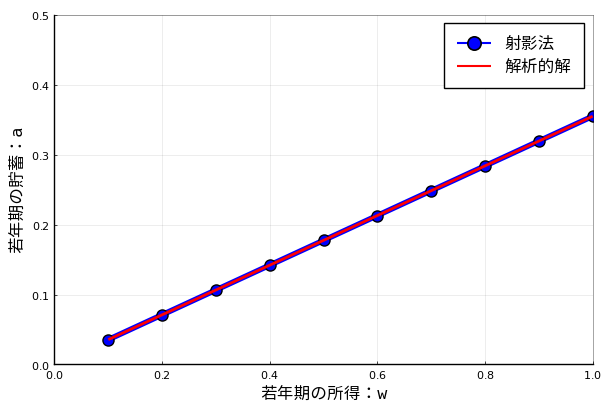

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/TomoakiYamada/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [14]:
plt = plot(params.grid_w, res[3],
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("射影法"),
    xlabel = ("若年期の所得：w"),
    ylabel = ("若年期の貯蓄：a"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="解析的解")
savefig("Fig2_pol_projection_method.pdf")

---

## エクササイズ
* グリッドの数を増やしてみよう
* 時限を増やしてみよう